# Checkpoint 8: Variational Autoencoder & Generative and adversarial models
---
*Responsible:* Guillermo Hamity (<ghamity@ed.ac.uk>)


Quickdraw was an interesting dataset but requires quite a lot of CPU to get decent results. We discussed a relatively good solution to the problem in the Lecture, but it is quite CPU intensive.

In order to make life a little easier in terms of training time, in this checkpoint exercise we will work with the MNIST dataset of hand-written digits. This time, though, we won't be classifying existing images, we will be generating new ones with generative models. 

- Exersice 1 and 2 we will build and use a Variational Autoencoder
- Exersice 3 we will use a Generative Adeverserial Network


These exercises build quite heavily on the ones on `AEs`. The network structure that worked on quickdraw should translate pretty well to MNIST, and hopefully perform better. You may be able to reuse some of your work, or you can look at my proposed solutions from last time for inspiration.


### Notes on assessment
* Try and calculate the answers to the exercises provided. If you are unable to complete the question, describe which approach you _would_ have taken to solve the problem
* Code must be understandable and reproducible. Before grading the notebook kernel **may** be restarted and re-run, so make sure that your code can run from start to finish without any (unintentional) errors
* If you are unsure on how to proceed please **ask one of the TAs** during the workshop
- Notebooks should be submitted by **10AM Friday** 
- This CP exercise sheet is divided into **3 sections** giving a maximum of **10 marks** in total:

| <p align='left'> Title                        | <p align='left'> Exercise nos. | <p align='center'> Number of marks |
| ------------------------------------------------------ | --------------------- | ------------------ |
| <p align='left'> 1. Build VAE                          | <p align='left'> 1–3  | <p align='left'> 4 |
| <p align='left'> 2. Compile and train a VAE            | <p align='left'> 4–6  | <p align='left'> 4 | 
| <p align='left'> 3. Generative adversarial network     | <p align='left'> 7–9  | <p align='left'> 2 |
| <p align='left'> **Total**                             |                       | <p align='left'> **10** |

## Preamble
---

In [1]:
# Standard import(s)
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



2023-01-19 23:52:12.804096: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Keras import(s)
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D, Conv2DTranspose, Concatenate, Lambda,BatchNormalization, UpSampling2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.backend import set_image_data_format
from keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last



## Data preprocessing
---

First, we'll load in the MNIST dataset from TensorFlow, which has already been split into training and testing parts for us.

In [3]:
# Load in MNIST dataset 
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Get numbers
nb_train   = X_train.shape[0]
nb_test    = X_test .shape[0]
nb_classes = y_train.max() + 1
print(f"Number of training examples: {nb_train}")
print(f"Number of testing  examples: {nb_test}")
print(f"Number of target classes:    {nb_classes}")

# Reshape inputs to (N,N,1), i.e. have one colour dimension
X_train = X_train[..., np.newaxis]
X_test  = X_test [..., np.newaxis]

# Standardise inputs
print("Max. input before scaling: {}".format(X_train.max()))
X_train = X_train / 255.
X_test  = X_test  / 255.

# Get image shape
shape = X_train.shape[1:]
print(f"Image shape:  {shape}")

# Shuffle (dataset is pre-shuffled, but still)
ix_train = np.random.permutation(nb_train)
ix_test  = np.random.permutation(nb_test)

X_train = X_train[ix_train]
y_train = y_train[ix_train]

X_test  = X_test [ix_test]
y_test  = y_test [ix_test]


Number of training examples: 60000
Number of testing  examples: 10000
Number of target classes:    10
Max. input before scaling: 255
Image shape:  (28, 28, 1)


The image below shows labels and images associated to them. They are in our standard (28,28,1) image format, as we had in quickdraw.

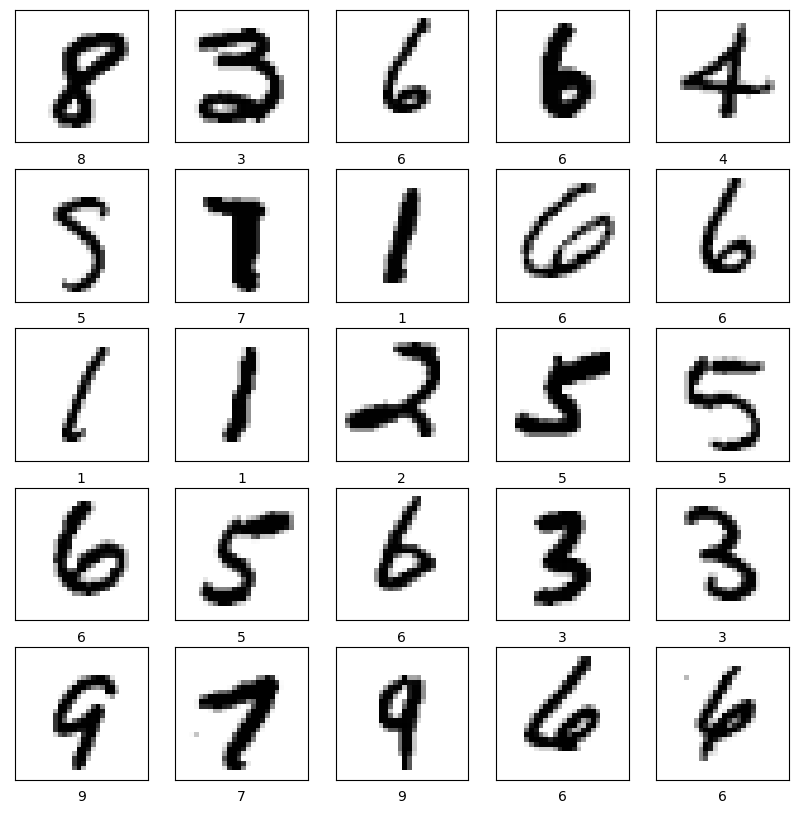

label marks [8 3 6 6 4 5 7 1 6 6 1 1 2 5 5 6 5 6 3 3 9 7 9 6 6]


In [4]:
nb_show = 25
plt.figure(figsize=(10,10))
for i in range(nb_show):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()
print("label marks",y_train[:nb_show])

## Variational auto-encoder (VAE) utilities
---
Below, I am providing you with some utility methods for training VAEs. This is done to minimsie the overhead in getting you up and running and training cool neural networks.

The first function implements the crucial element for _variational_ auto-encoders: The random sampling in the latent space. The `sampling` function below takes one argument, which is assumed to be a list with two element: the means and the logarithm of the variances, respectively, of the latent probability density function (p.d.f.) for a given image example. The function then samples random numbers, and scales them such that they are effectively drawn from a p.d.f. with means and standard deviations as given by `args`. These sampled coordinates in the latent space are then returned.

In [5]:
def sampling (args):

  # Unpack arguments
  z_mean, z_log_var = args

  # Get shape of random noise to sample
  epsilon = K.random_normal(shape=K.shape(z_mean))

  # Return samples from latent space p.d.f.
  return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Build a VAE (4 marks)

#### 1. Build the encoder of the VAE (1.5 mark)

Build an encoder. We will train for 50 epoches so a relatively fast NN may be desiriable. Here you have some freedom but some example structure is given:
- the input layer has the dimension of the shape
- Flat the input layer (either with or without convolution beforehand)
    - The `1 2 4 8 16` convolution example worked well for me, but is a bit slower.
- add a few hidden Dense layer (with relu activation function) with 256 dimension of hidden nodes
- Add the 2 special layers:
    * `z_mean` contains the means of the latent space p.d.f. for a given image, and
    * `z_log_var` contains the logarithm of the assocated variances. 
- Pass these 2 layers into a layer `z` that just apply the `sampling` method above. Note: the sampling method is used to perform the reparametrization trick. `Lambda` has to be used to ensure the gradients to be computed (see Lecture example) 
- Output the 3 layers (z_mean, z_log_var and z)
- build the encoder model with the `Model` method. 
    - If you used convolution and pooling make sure you complient this with Upsampleling and ConvolutionTranspose. 
    - A good structure here is to invert the stucture of the encoder, e.g. `16 8 4 2 1`.

In [6]:
intermediate_dim =256
latent_dim = 2

visible = Input(shape=(28,28,1))
x = Flatten()(visible)


h = Dense(intermediate_dim, activation='relu')(x)
h = Dense(intermediate_dim, activation='relu')(h)
h = Dense(intermediate_dim, activation='relu')(h)

z_mean = Dense(latent_dim, name="z_mean")(h)
z_log_var = Dense(latent_dim, name="z_log_var")(h)
z = Lambda(sampling, output_shape=(latent_dim, ), name = "z")([z_mean, z_log_var])
encoder = Model(visible,[z_mean, z_log_var, z], name = "encoder")

encoder.summary()





Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten (Flatten)              (None, 784)          0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 256)          200960      ['flatten[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[0][0]']                  
                                                                                            

#### 2. Build the decoder of the VAE (1.5 mark)

Build a decoder:
- the input layer has the latent space 2
- Apply 2 hidden Dense layers with dimension 256 (same number as in the encoder) and relu activation function
- Output sigmoid activation function such that it ends up with the same shape as the original image, with pixel intensities in the range $[0, 1]$.
    - use as dimension of this layer `np.prod(shape)`, where shape is the latent space.
- then reshape the output to the original image shape with `Reshape` method. This step is needed to bring back the data from shape (latent_dim, ) into some shape that can be reshaped into the output shape of the last layer of our encoder.
- build the decoder model with the `Model` method

In [7]:
decoder_input = Input(shape=(latent_dim,))
h = Dense(intermediate_dim, activation="relu")(decoder_input)
h = Dense(intermediate_dim, activation="relu")(h)
output_h = Dense(np.prod(shape), activation='sigmoid')(h)
output_reshape = Reshape(shape)(output_h)
decoder = Model(inputs=decoder_input, outputs=output_reshape,name="decorder")
decoder.summary()

Model: "decorder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_3 (Dense)             (None, 256)               768       
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 784)               201488    
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


#### 3. Build the VAE model (1 mark)

Then, we can connect the encoder and the decoder. 
- Build the VAE model using `Model` method using `i` (encoder) and `o` (decoder)
- plot the model with the `plot_model` method

In [8]:
## Chain together to get VAE
i = encoder.inputs
if len(i) == 1:
 i = i[0]
 pass
z = encoder(i)[2]
o = decoder(z)

In [9]:
vae = Model(i, o, name='ConvAE')
vae.summary()


Model: "ConvAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               333572    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decorder (Functional)       (None, 28, 28, 1)         268048    
                                                                 
Total params: 601,620
Trainable params: 601,620
Non-trainable params: 0
_________________________________________________________________


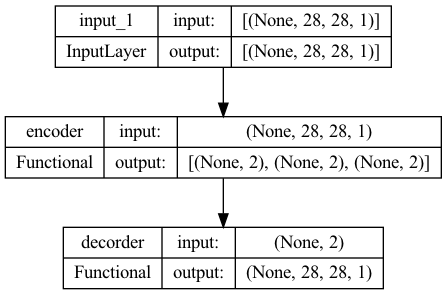

In [10]:
plot_model(vae,show_shapes = "True")

# Compile and train the VAE model (3 marks)

The `compile_vae` methods compiles the VAE model passed as the sole argument. The method computes

1. the image reconstruction loss (`reco_loss`), as well as
2. the Kullback-Leibler (KL) loss (`kl_loss`) for the latent space p.d.f.

The first loss measures how well the VAE is doing at reconstructing the input images; the second loss quantifies how continuous the latent representation is. The two losses are then summed (and added as separate metrics for monitoring), and the VAE model is compiled with the Adam optimiser.

In [11]:
def compile_vae (vae):

    # Get the latent p.d.f. mean and log-variance output layers from VAE encoder
    encoder   = vae.get_layer('encoder')
    z_log_var = encoder.get_layer('z_log_var').output
    z_mean    = encoder.get_layer('z_mean').output

    # Define reconstruction loss
    def reco_loss (y_true, y_pred):
        # Use binary cross-entropy loss
        reco_loss_value = binary_crossentropy(y_true, y_pred) # Averages over axis=-1
        reco_loss_value = K.sum(reco_loss_value, axis=(1,2))
        return reco_loss_value

    # Define Kullback-Leibler loss with reference to encoder output layers
    def kl_loss (y_true, y_pred):
        kl_loss_value = 0.5 * (K.square(z_mean) + K.exp(z_log_var) - 1. - z_log_var)
        kl_loss_value = K.sum(kl_loss_value, axis=-1)
        return kl_loss_value

    # Define VAE loss
    def vae_loss (y_true, y_pred):
        return reco_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

    vae.compile(optimizer='adam', loss=vae_loss, metrics=[reco_loss, kl_loss])
    return

#### 4. Construct, compile, and train a VAE using the methods provided above (1 mark)

* Compile the model.
* Train for ca. **50 epochs**.
* Plot the all of the loss histories in `vae.history.history`. Use a suitable fraction of training data for validation

In [12]:
# Define parameters
latent_dim =  2
nb_epochs  =  50
batch_size = 128

In [13]:
compile_vae(vae)


In [14]:
results = vae.fit(X_train,X_train,epochs=nb_epochs, batch_size=batch_size,validation_split =0.2,verbose=1)

Train on 48000 samples, validate on 12000 samples


2023-01-19 23:52:26.366132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 23:52:26.416571: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch 1/50
47744/48000 [============================>.] - ETA: 0s - loss: 203.7051 - reco_loss: 199.4918 - kl_loss: 4.2133

/Users/aurovaratpatnaik/opt/anaconda3/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


48000/48000 [==============================] - 6s 135us/sample - loss: 203.5580 - reco_loss: 199.3452 - kl_loss: 4.2128 - val_loss: 177.5731 - val_reco_loss: 173.6149 - val_kl_loss: 3.9582
Epoch 2/50
48000/48000 [==============================] - 6s 125us/sample - loss: 173.3200 - reco_loss: 168.8696 - kl_loss: 4.4504 - val_loss: 168.7602 - val_reco_loss: 164.0333 - val_kl_loss: 4.7269
Epoch 3/50
48000/48000 [==============================] - 4s 91us/sample - loss: 165.1485 - reco_loss: 160.0569 - kl_loss: 5.0916 - val_loss: 162.7260 - val_reco_loss: 157.3254 - val_kl_loss: 5.4005
Epoch 4/50
48000/48000 [==============================] - 6s 115us/sample - loss: 160.6513 - reco_loss: 155.2971 - kl_loss: 5.3543 - val_loss: 159.3325 - val_reco_loss: 154.1003 - val_kl_loss: 5.2322
Epoch 5/50
48000/48000 [==============================] - 6s 126us/sample - loss: 158.5892 - reco_loss: 153.1132 - kl_loss: 5.4760 - val_loss: 157.6565 - val_reco_loss: 151.9464 - val_kl_loss: 5.7101
Epoch 6/50
4

In [15]:
history = results.history

keys = list(history.keys())

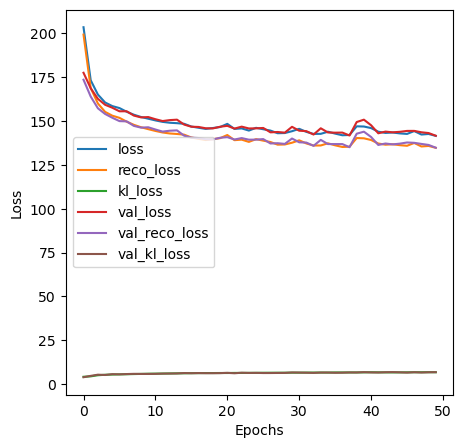

In [16]:


fig, ax = plt.subplots(figsize=(5,5))
# plt.plot(history["loss"],label="Keras Loss")
for key in keys:
 
    plt.plot(np.arange(nb_epochs),history[key],label=key)

plt.legend()

ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")
plt.show()

#### 5. Predict the test digits into the 2D laten space (1 mark)

- Use the encoder to predict images into the laten space
- Make a scatter plot per digit (use masking, see our first ML Lecture 2) and include a legend
- Include a grid.
- Discuss the results. Why do you think some digits overlap, and why are some clearly seperated? 

    VAE is trying to learn the underlying probability distribution of the data. Therefore, the latent space will have a structure that reflects the relationships between different digits.  Some digits are more similar to each other, and they will be encoded in similar regions of the latent space, resulting in overlapping images. Other digits are less similar, and they will be encoded in different regions of the latent space, resulting in clearly separated images. For example, 3 and 5 share a very similar bottom half, their regions ( red and brown are overlapping, the color might change if I have ran it again) have some overlap. Interestingly, there is overlap between 4 and 9 possibly due to their similar shape of a line curving back in. Numbers like 1 and 0 are far apart in the latent space due to their obvious dissimilarity.



In [17]:
encoded_imags = encoder.predict(X_test)

/Users/aurovaratpatnaik/opt/anaconda3/envs/daml/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


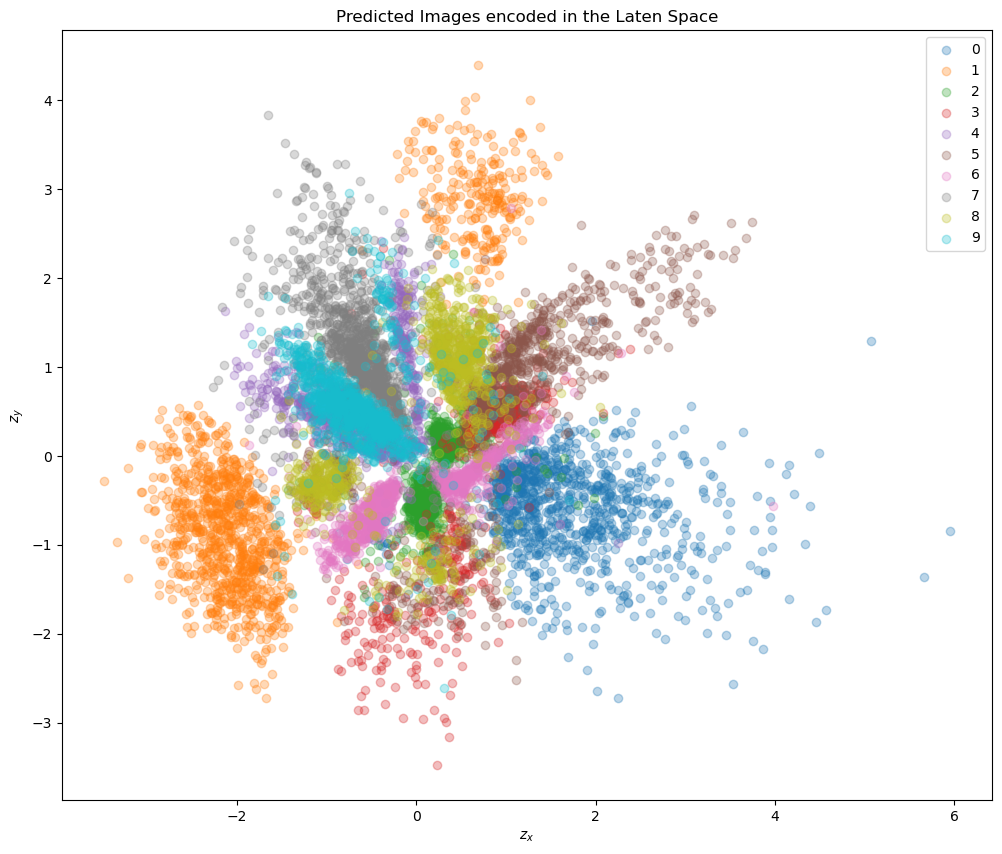

In [110]:

plt.figure(figsize=(12, 10))
for i in range(10):
    
    plt.scatter(*zip(*encoded_imags[2][y_test == i]), alpha=0.3,label = i)
plt.title("Predicted Images encoded in the Laten Space")
plt.xlabel(r'$z_{x}$')
plt.ylabel(r'$z_{y}$')
plt.legend()
plt.show()


#### 6. Generate samples across the latent space of the VAE (2 marks)

* Define an equally-spaced set of $\boldsymbol{N \approx 10}$ **points** along each of the two latent dimensions, that you want to sample (_e.g._ using the `np.linspace` method in the range $(-2,2)$). You can play around with this range in order to focus on areas you personally think might be interesting (look at your grid plot above).
* Convert these into a grid of pairs of coordinates using the `np.meshgrid` method.
* Define an $(N^{2}, 2)$ array, and fill it with all of these pairs of latent space coordinates (you'll need to `flatten` the two outputs from `np.meshgrid`).
* Get the decoder predictions (_i.e._ the generated images) for this set of $N^{2}$ coordinates in the latent space.
* Display them in a grid, _e.g._ using the `plt.imshow` method.
* Discuss the results.

    By looking at the region of the latent space that's in the center, we can see how the VAE has learned to understand the relationships between different digits. The overlap of different digits in the center of the grid plot suggests that the VAE has learned to group similar digits together. For example in the output below, digits that are structurally similar like 3 and 6 or  8 or 9 and 7 are placed close to each other in the latent space and the generated images for these digits are also similar. This indicates that the VAE has learned to recognize the underlying structure of the data.

    As we move across the latent space, we can see that the generated images change gradually, showing that the VAE is able to generate plausible images for all points in the latent space. We can also observe that the model has learned to generate images that lie in the same region of the latent space but can still have different variations. For example, different styles of handwriting or variations of the same digit are all placed in close proximity in the latent space, indicating that the VAE has learned to recognize the underlying variations in the data.

In [86]:
N = 10

digit_size = 28
grid = np.linspace(-1, 1, N)
grid_x, grid_y = np.meshgrid(grid,grid)
figure = np.empty((digit_size * N, digit_size * N,1))

decoder_input = np.empty([N**2, 2])
decoder_input[:,0] = grid_x.flatten()
decoder_input[:,1] = grid_y.flatten()


decoder_output = decoder.predict(decoder_input)


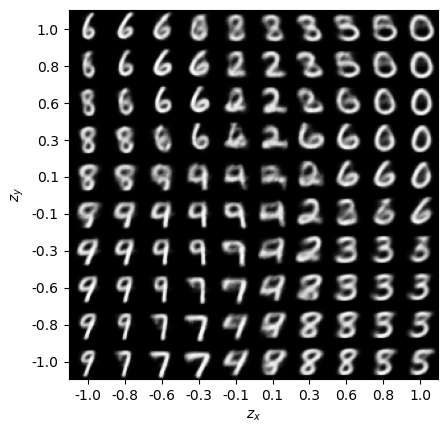

In [111]:
for no in range(N**2):
    i,j = no//10,no%10
    figure[i*digit_size:(i+1)*digit_size,j*digit_size:(j+1)*digit_size] = decoder_output[no]

plt.imshow(figure, cmap="Greys_r")

start_range = digit_size // 2
end_range = N * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid, 1)
sample_range_y = np.round(grid[::-1], 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel(r'$z_{x}$')
plt.ylabel(r'$z_{y}$')
plt.show()

# Generative Adversarial networks (2 marks)

Putting together a GAN by yourself is a big task and outside the scope of what we can cover.

Instead here we provide the building blocks for creating the GAN on the MNIST dataset. Your task is to go through individual components and show your understanding. The source material can be found [here](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) with ample explenations, so think of it as a short literature review, the point being to get you to engage with the material.


**Suggestion**: you could choose to answer the question in the same markdown block they are asked. Make the answer distiguishable by for example using a seperator by typing `---` on a new line.



#### 7. Discuss components of generative adverserial NN (0.5 marks)




In [88]:
# all imports needed from here
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.mnist import load_data
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from matplotlib import pyplot
 

---

- Defined is the discriminator model using the `Sequential` keras function
    - What is the purpose of the discriminator?
    - Discuss the structure. What are the LeakyReLU and Dropout layers?
    - Why is binary crossentropy used as the loss function?

    - The discriminator in GANs is a neural network that tries to differentiate between real and fake data, in esseence a binary classification model. It helps in the training of generator network by providing feedback on how well the generator is doing on producing realistic data. 
  
    - The structure of the model is a convolutional neural network (CNN). It starts with a 2D convolutional layer with 64 filters of size (3x3) and stride (2,2). This is followed by a LeakyReLU activation function, which is an improved version of ReLU, that allows small negative values to pass through. This helps to avoid the dying ReLU problem. The model also uses a Dropout layer with a rate of 0.4, which helps to avoid overfitting by randomly dropping out some neurons during training. The next layer is again the 2D convolutional layer with 64 filters, LeakyReLU and Dropout layers. After these layers, the model flattens the data, and finally, the last layer is a dense layer with one unit, and a sigmoid activation function.

    - The binary cross-entropy loss function is used in this model as the output of the discriminator is a probability value between 0 and 1, and it is used to classify the input as either real or fake. The sigmoid function used in the last layer of the model is used to produce the probability values, and the binary cross-entropy loss function is used to measure the dissimilarity between the predicted probability and the actual label.

In [89]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0

/Users/aurovaratpatnaik/opt/anaconda3/envs/daml/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


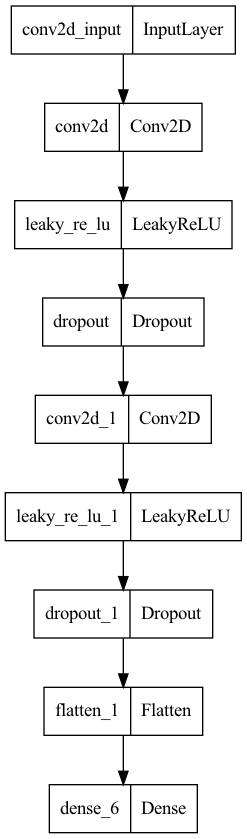

In [90]:
# create the discriminator
d_model = define_discriminator()
d_model.summary()
plot_model(d_model)

---
- Defined is the generator model
    - What is used as input to the generative model?
    - What is the Conv2DTranspose layer used for?
    - Why is sigmoid used as the activation function?

    - The input to the generator model is a noise, typically a random noise vector with a fixed dimension (latent_dim) signifying a point in the latent space. The generator will use this noise as the seed to generate new data that is similar to the real data.
  
    - The Conv2DTranspose layer is used for upsampling the input. It is the transpose of a 2D convolutional layer. It is used to increase the spatial resolution of the input by inserting zeros between the elements of the input and then applying a convolution operation. This is the key component in the generator model as it allows the model to generate new images with a higher resolution.
 
    - The sigmoid activation function is used in the last layer of the generator model as the output of the generator is an image, which is a matrix of pixel values between 0 and 1. The sigmoid function maps the input values to a range between 0 and 1, which is the same range as the pixel values of the images. This activation function helps the generator to produce images that are similar to the real images. 

In [91]:
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

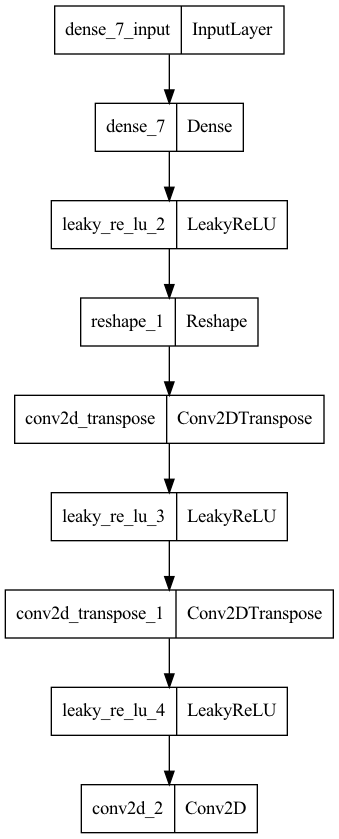

In [92]:
# size of the latent space
latent_dim = 100
# create the generator
g_model = define_generator(latent_dim)
g_model.summary()
plot_model(g_model)

---
- We define the GAN model as a sequence of both generator and discriminator
    - Explain the order of the sequence, and the flow of input to output, through the generator and discriminator
    - Notice the discriminator is not trainable in the gan model. Can you think of why that might be? This may become clear when we discuss the training loop.

    - The generator is the first layer in the sequence and the output of this layer is passed as the input to the discriminator, which is the second layer in the sequence. 
      
      The flow of input to output in the GAN model:
      1. The GAN model takes a noise vector as input, which is passed to the generator. 
      2. The generator uses this noise vector to generate new data, which is then passed as input to the discriminator. 
      3. The discriminator then classifies the input as either real or fake.

    - In this GAN model, the discriminator is not trainablele because the goal of the GAN training is to update the generator to generate more realistic data, so that it can fool the discriminator. Therefore, the generator and discriminator are trained separately. The generator is trained to generate data that can fool the discriminator, and the discriminator is trained to correctly classify the real and fake data. By freezing the weights of the discriminator during the training of the GAN model, the generator is only updated based on the gradients of the loss function with respect to its own parameters, rather than the gradients of the discriminator's parameters. This allows the generator to learn and improve without the influence of the discriminator's weights.

In [93]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 28, 28, 1)         1164289   
                                                                 
 sequential (Sequential)     (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


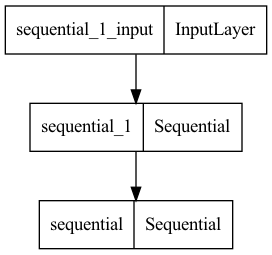

In [94]:
# create the gan
gan_model = define_gan(g_model, d_model)
gan_model.summary()
plot_model(gan_model)

---
##### 8. Discuss the training datasets (0.5 marks)

- Given are real mnist datasets. 
- `load_real_samples` prepares mnist
- `generate_real_samples` allows us to select a subset of data for batch training
    - what is this data used for?
    - what is the `y = ones((n_samples, 1))` varible used for?

    - The data output generate_real_samples function allows us to take a small subset of the prepared data, and it's used to train the discriminator in batches.
  
    - The y = ones((n_samples, 1)) variable is used to tell the discriminator that the data it's seeing is real and not fake. This variable is used as a label and is passed as the target variable when training the discriminator.

In [95]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	y = ones((n_samples, 1))
	return X, y
 

---
- Given are functions to generate random numbers from laten space
    - use `generate_fake_samples` to create a single random image propegated through the generator. Discuss the result.

    - The result has the same shape as the real images but the result is nonsensical, it does not represent any number.

In [96]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

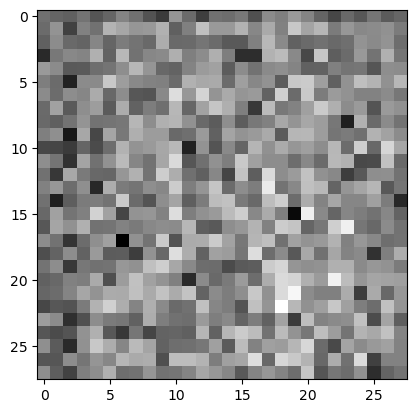

In [107]:
plt.imshow(generate_fake_samples(g_model,latent_dim,1)[0].reshape((28,28,1)),cmap="Greys_r")
plt.show()

---
Some functions for saving GAN models and output images

In [97]:
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
# evaluate the discriminator, plot generated images, save generator model

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename) 

#### 9 Training the GANs (1 marks)

The GAN training sequnce is done in batches of data per epoch. Because the generator weights cannot be updated in the standard way, this is done iteratively in a loop. 


- Discuss the lines within the `j` loop. Explain how the generator and discriminator are trained in this context. 

Within the j loop, the function first generates a random subset of real samples from the dataset using the generate_real_samples function. Then, it generates a random subset of fake samples using the generate_fake_samples function. The real and fake samples are then combined to create the training set for the discriminator. The discriminator model is then updated using this training set by calling the train_on_batch function.

Then, the function generates random points in the latent space using the generate_latent_points function as input for the generator. The generator model is then updated by calling the train_on_batch function on the GAN model, which takes the generator and the discriminator as input layers. The generator is updated based on the gradients of the loss function with respect to its own parameters, rather than the gradients of the discriminator's parameters. The summary of the loss is then printed out.

The generator and discriminator are trained in this context by first generating random subsets of real and fake samples and then using them to update the discriminator model. Then, random points in the latent space are generated and used to update the generator model via the GAN model. This process is repeated for the specified number of epochs and batches.

In [98]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 2 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 

- Train the GAN model. 
    - This takes a very long time, so I would recommend aiming for 3 epochs and checking the figures that are generated (saved locally). They won't be good, but you will get some idea already that we don't have random noise
    - Discuss the print out. How do the loss functions change over time?
    - Generate some images with your new number generator and plot them. 
    - Feel free to try for more epoches (if you insist!). If you have a GPU or some hours to waste, 10 should start showing some good digits, and by 50 you should get some good results.

In [108]:
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=1)

>1, 1/234, d=0.694, g=0.713
>1, 2/234, d=0.683, g=0.721
>1, 3/234, d=0.682, g=0.740
>1, 4/234, d=0.676, g=0.751
>1, 5/234, d=0.665, g=0.767
>1, 6/234, d=0.659, g=0.775


KeyboardInterrupt: 